# Connection à l'API de Gemini

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
google_API_TOKEN = os.getenv("GOOGLE_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [ ]:
llm.invoke("Sing a ballad of LangChain.")

In [7]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
import datetime
from discord import Poll

@tool
def create_poll(
    question: str,
    answers: str,
    duration: int = 24,
    answers_emoji: str = None,
    multiple: bool =True,
):
    """
    Commande pour créer un sondage avec réactions.
    """
    answers = answers.split()
    answers_emoji = answers_emoji.split()
    
    poll = Poll(question,datetime.timedelta(hours=duration),multiple=multiple)

    for answer, emoji in zip(answers, answers_emoji):
        print(f'Answers :{answer},{emoji}')
        poll.add_answer(text=answer, emoji=emoji)

    return Poll


tools = [create_poll]

graph = create_react_agent(llm, tools=tools)

In [5]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [12]:
inputs = {"messages": [("user", "Je veux que tu crées un sondage simple et attractif sur les fruits. La question principale doit être : 'Quel est votre fruit préféré ?'. Propose des choix de réponse variés et populaires, comme :Pomme 🍏, Banane 🍌, Orange 🍊,Fraise🍓, Mangue 🥭, Raisin 🍇")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Je veux que tu crées un sondage simple et attractif sur les fruits. La question principale doit être : 'Quel est votre fruit préféré ?'. Propose des choix de réponse variés et populaires, comme :Pomme 🍏, Banane 🍌, Orange 🍊,Fraise🍓, Mangue 🥭, Raisin 🍇
================================== Ai Message ==================================
Tool Calls:
  create_poll (7c565f9f-0024-4df9-9e36-0060ac0d6928)
 Call ID: 7c565f9f-0024-4df9-9e36-0060ac0d6928
  Args:
    answers: Pomme 🍏, Banane 🍌, Orange 🍊, Fraise 🍓, Mangue 🥭, Raisin 🍇
    question: Quel est votre fruit préféré ?
================================= Tool Message =================================
Name: create_poll

Error: AttributeError("'NoneType' object has no attribute 'split'")
 Please fix your mistakes.
================================== Ai Message ==================================

Il y a eu une erreur lors de la création du sondage. Je vais réessayer en

In [13]:
from typing import List

# this is the state schema used by the prebuilt create_react_agent we'll be using below
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.documents import Document


class State(AgentState):
    docs: List[str]

In [14]:
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState


@tool
def get_context(question: str, state: Annotated[dict, InjectedState]):
    """Get relevant context for answering the question."""
    return "\n\n".join(doc for doc in state["docs"])

In [ ]:
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

tools = [get_context]

# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

checkpointer = MemorySaver()
graph = create_react_agent(llm, tools, state_schema=State, checkpointer=checkpointer)

In [ ]:
docs = [
    "FooBar company just raised 1 Billion dollars!",
    "FooBar company was founded in 2019",
]

inputs = {
    "messages": [{"type": "user", "content": "what's the latest news about FooBar"}],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [1]:
from datetime import datetime, timedelta

def prochain_mercredi(date_reference: datetime = None) -> datetime:
    """
    Retourne la date du prochain mercredi à partir de la date de référence donnée.
    Si aucune date de référence n'est fournie, utilise la date actuelle.
    """
    date_reference = date_reference.date() if date_reference else datetime.today().date()
    
    # Calcul des jours à ajouter pour atteindre mercredi (mercredi = 2)
    jours_a_ajouter = (2 - date_reference.weekday()) % 7 or 7  # Assure le mercredi suivant
    
    return datetime.combine(date_reference + timedelta(days=jours_a_ajouter), datetime.min.time())

def prochain_mercredi(date_reference: datetime = None) -> datetime:
    """
    Retourne la date du prochain mercredi à 21h15 à partir de la date de référence donnée.
    Si aucune date de référence n'est fournie, utilise la date actuelle.
    
    :param date_reference: Une date de référence optionnelle (datetime).
    :return: Un objet datetime représentant le prochain mercredi à 21h15.
    """
    date_reference = date_reference if date_reference else datetime.today()
    
    # Calcul des jours à ajouter pour atteindre mercredi (mercredi = 2)
    jours_a_ajouter = (2 - date_reference.weekday()) % 7 or 7  # Assure le mercredi suivant
    
    return datetime.combine(date_reference.date() + timedelta(days=jours_a_ajouter), datetime.min.time().replace(hour=21, minute=15))

def discord_timestamps(date: datetime, format: str = 'f') -> str:
    """
    Génère un timestamp Discord à partir d'une date.
    
    :param date: Un objet datetime
    :param format: Format du timestamp Discord ('F', 'f', 'D', 'd', 'T', 't', 'R')
    :return: Une chaîne de caractères compatible avec Discord
    """
    accepted_formats = {'F', 'f', 'D', 'd', 'T', 't', 'R'}
    
    if format not in accepted_formats:
        raise ValueError(f"Format non pris en charge. Formats acceptés : {', '.join(accepted_formats)}")
    
    timestamp = int(date.timestamp())  # Convertir en timestamp Unix
    return f'<t:{timestamp}:{format}>'

In [2]:
discord_timestamps(prochain_mercredi())

'<t:1749064500:f>'

In [3]:
print(f"## Hey! N'oubliez pas de voter pour le film de la watchparty ! La soirée film aura lieu {discord_timestamps(prochain_mercredi())} ({discord_timestamps(prochain_mercredi(), format='R')})")

## Hey! N'oubliez pas de voter pour le film de la watchparty ! La soirée film aura lieu <t:1749064500:f> (<t:1749064500:R>)


In [4]:
import requests

url = "https://api.imdbapi.dev/search/titles"
params = {"query": "strange Things"}

response = requests.get(url, params=params, headers={"accept": "application/json"})

print(response.status_code)
print(response.json())


200
{'titles': [{'id': 'tt1338552', 'type': 'movie', 'primaryTitle': 'Strange Things', 'originalTitle': 'Strange Things', 'primaryImage': {'url': 'https://m.media-amazon.com/images/M/MV5BMjAxNzE5NTIyMV5BMl5BanBnXkFtZTcwNTAwMjAxNw@@._V1_.jpg', 'width': 673, 'height': 997}, 'startYear': 2010, 'rating': {'aggregateRating': 7, 'voteCount': 22}}, {'id': 'tt4574334', 'type': 'tvSeries', 'primaryTitle': 'Stranger Things', 'originalTitle': 'Stranger Things', 'primaryImage': {'url': 'https://m.media-amazon.com/images/M/MV5BNjRiMTA4NWUtNmE0ZC00NGM0LWJhMDUtZWIzMDM5ZDIzNTg3XkEyXkFqcGc@._V1_.jpg', 'width': 1080, 'height': 1350}, 'startYear': 2016, 'endYear': 2025, 'rating': {'aggregateRating': 8.6, 'voteCount': 1533556}}, {'id': 'tt0049177', 'type': 'movie', 'primaryTitle': 'Elena and Her Men', 'originalTitle': 'Elena et les hommes', 'primaryImage': {'url': 'https://m.media-amazon.com/images/M/MV5BYzUzYWJjZmMtYjUxZC00ZmYxLWEyY2YtMThjNjEyMDhjMDZlXkEyXkFqcGc@._V1_.jpg', 'width': 1276, 'height': 1701}

In [2]:
def search_imdb_titles(query: str):
    url = "https://api.imdbapi.dev/search/titles"
    params = {"query": query}

    response = requests.get(url, params=params, headers={"accept": "application/json"})
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

In [12]:
def get_imdb_title_details(title_id: str):
    url = f"https://api.imdbapi.dev/titles/{title_id}"

    response = requests.get(url, headers={"accept": "application/json"})
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": f"Request failed with status code {response.status_code}"}

In [19]:
def first_result_title_details(query: str):
    search_results = search_imdb_titles(query)
    if "titles" in search_results and len(search_results["titles"]) > 0:
        first_title_id = search_results["titles"][0]["id"]
        return get_imdb_title_details(first_title_id)
    else:
        return {"error": "No titles found for the given query."}

In [31]:
def prepare_message(title_details: dict):
    if "error" in title_details:
        return title_details["error"]
    
    message = f"Title: {title_details.get('primaryTitle')}\n"
    message += f"Rating: {title_details.get('rating').get('aggregateRating')}\n"
    message += f"Genres: {', '.join(title_details.get('genres', []))}\n"
    message += f"Plot: {title_details.get('plot')}\n"
    
    return message

In [36]:
title = "Brightburn"
data = search_imdb_titles(title)

In [37]:
info = first_result_title_details(title)

In [38]:
info

{'id': 'tt7752126',
 'type': 'movie',
 'primaryTitle': 'Brightburn',
 'primaryImage': {'url': 'https://m.media-amazon.com/images/M/MV5BMTBhNDcwNzYtOWE3Mi00MGU1LWI1YTAtOTJiZjIzODRjMjc2XkEyXkFqcGc@._V1_.jpg',
  'width': 6072,
  'height': 9000},
 'startYear': 2019,
 'runtimeSeconds': 5400,
 'genres': ['Drama', 'Horror', 'Mystery', 'Sci-Fi'],
 'rating': {'aggregateRating': 6.1, 'voteCount': 117975},
 'metacritic': {'score': 44, 'reviewCount': 31},
 'plot': 'An alien that looks like a human boy uses its powers in sinister and destructive ways.',
 'directors': [{'id': 'nm0946521',
   'displayName': 'David Yarovesky',
   'alternativeNames': ['Dave Yarvo', 'Yarvo'],
   'primaryImage': {'url': 'https://m.media-amazon.com/images/M/MV5BNWU4OTZiYzctMWI0NC00M2VjLTk0OGUtYjhhMDFkNjBhNjVmXkEyXkFqcGc@._V1_.jpg',
    'width': 1624,
    'height': 2436},
   'primaryProfessions': ['director', 'editor', 'producer']}],
 'writers': [{'id': 'nm0348160',
   'displayName': 'Brian Gunn',
   'primaryProfessions': 

In [35]:
print(prepare_message(info))

Title: Stranger Things
Rating: 8.6
Genres: Drama, Fantasy, Horror, Mystery, Sci-Fi, Thriller
Plot: In 1980s Indiana, a group of young friends witness supernatural forces and secret government exploits. As they search for answers, the children unravel a series of extraordinary mysteries.



In [1]:
import requests
from PIL import Image
from io import BytesIO


def images_urls_to_bytes_horizontal(
    urls: list[str],
    target_height: int | None = None,
    background=(255, 255, 255, 0)
) -> bytes:
    """
    Télécharge des images depuis des URLs, les colle horizontalement
    et retourne l'image finale en bytes (PNG).
    """

    images = []

    # 1. Télécharger les images
    for url in urls:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")
        images.append(img)

    if not images:
        raise ValueError("Aucune image fournie")

    # 2. Déterminer la hauteur cible
    if target_height is None:
        target_height = max(img.height for img in images)

    # 3. Redimensionner à hauteur identique
    resized_images = []
    total_width = 0

    for img in images:
        ratio = target_height / img.height
        new_width = int(img.width * ratio)
        resized = img.resize((new_width, target_height), Image.LANCZOS)
        resized_images.append(resized)
        total_width += new_width

    # 4. Créer l'image finale
    final_img = Image.new("RGBA", (total_width, target_height), background)

    x_offset = 0
    for img in resized_images:
        final_img.paste(img, (x_offset, 0), img)
        x_offset += img.width

    # 5. Conversion en bytes
    buffer = BytesIO()
    final_img.save(buffer, format="PNG")
    buffer.seek(0)

    return buffer.getvalue()


In [2]:
list_urls = [
    'https://m.media-amazon.com/images/M/MV5BNWU4OTZiYzctMWI0NC00M2VjLTk0OGUtYjhhMDFkNjBhNjVmXkEyXkFqcGc@._V1_.jpg',
    'https://m.media-amazon.com/images/M/MV5BMTBhNDcwNzYtOWE3Mi00MGU1LWI1YTAtOTJiZjIzODRjMjc2XkEyXkFqcGc@._V1_.jpg',
    'https://m.media-amazon.com/images/M/MV5BZjUyY2RhODEtNTZkNC00M2Q1LTljZTctOTk2ZDAwMTMxMDJmXkEyXkFqcGc@._V1_.jpg',
]

image_bytes = images_urls_to_bytes_horizontal(list_urls, target_height=300)

(np.float64(-0.5), np.float64(669.5), np.float64(299.5), np.float64(-0.5))

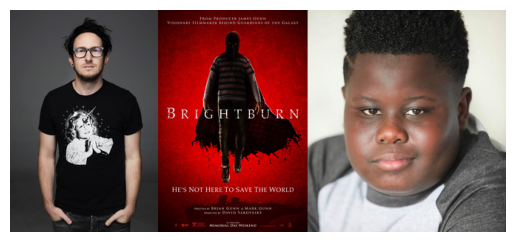

In [3]:
import matplotlib.pyplot as plt
img = Image.open(BytesIO(image_bytes))
plt.imshow(img)
plt.axis('off')